In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries
import requests
import sklearn 


In [ ]:
config = {
    "alpha_vantage": {
        "key": "JIQEK9ASFPJJI3D8", # Claim API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "IBM", #IBM
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, 
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Number of data points: 306 from 1999-12-31 to 2025-05-07


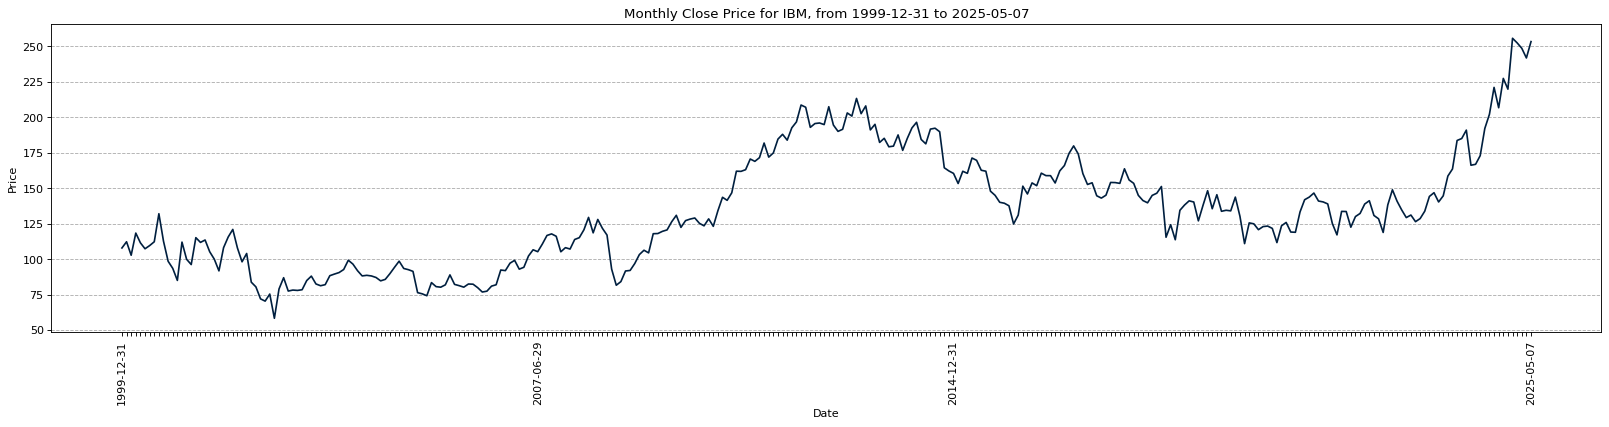

In [3]:
def download_data(config, plot=False):
    # Get data from Alpha Vantage using the free Monthly API
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={config["alpha_vantage"]["symbol"]}&apikey={config["alpha_vantage"]["key"]}'
    response = requests.get(url)
    data = response.json()
    
    if "Monthly Time Series" not in data:
        raise ValueError("Error retrieving data from Alpha Vantage: " + str(data))
    
    time_series = data["Monthly Time Series"]
    data_date = list(time_series.keys())
    data_date.sort()
    
    data_close_price = [float(time_series[date]["4. close"]) for date in data_date]
    data_close_price = np.array(data_close_price)
    
    num_data_points = len(data_date)
    display_date_range = f"from {data_date[0]} to {data_date[-1]}"
    print("Number of data points:", num_data_points, display_date_range)
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        
        xticks = [data_date[i] if ((i % config["plots"]["xticks_interval"] == 0 and (num_data_points - i) > config["plots"]["xticks_interval"]) or i == num_data_points - 1) else None for i in range(num_data_points)]
        x = np.arange(0, len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        
        plt.title(f"Monthly Close Price for {config['alpha_vantage']['symbol']}, {display_date_range}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(which='major', axis='y', linestyle='--')
        plt.show()
    
    return data_date, data_close_price, num_data_points, display_date_range
data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

In [4]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize values
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

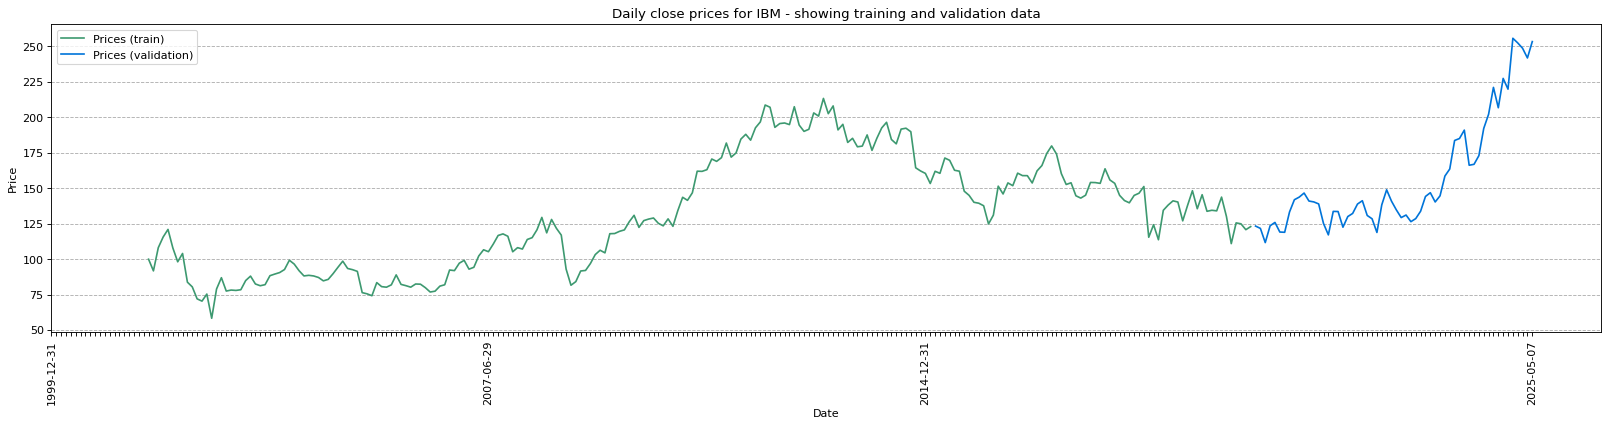

In [5]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")

        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])
     

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) 
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (228, 20, 1) (228,)
Validation data shape (58, 20, 1) (58,)


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features]
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [8]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create dataloaders
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.031160, test:0.005290 | lr:0.010000
Epoch[2/100] | loss train:0.011522, test:0.007390 | lr:0.010000
Epoch[3/100] | loss train:0.007776, test:0.003936 | lr:0.010000
Epoch[4/100] | loss train:0.005839, test:0.003052 | lr:0.010000
Epoch[5/100] | loss train:0.004876, test:0.003962 | lr:0.010000
Epoch[6/100] | loss train:0.005171, test:0.003185 | lr:0.010000
Epoch[7/100] | loss train:0.004229, test:0.002829 | lr:0.010000
Epoch[8/100] | loss train:0.004459, test:0.003166 | lr:0.010000
Epoch[9/100] | loss train:0.004298, test:0.002825 | lr:0.010000
Epoch[10/100] | loss train:0.004142, test:0.002780 | lr:0.010000
Epoch[11/100] | loss train:0.003711, test:0.002714 | lr:0.010000
Epoch[12/100] | loss train:0.004099, test:0.002360 | lr:0.010000
Epoch[13/100] | loss train:0.004356, test:0.002692 | lr:0.010000
Epoch[14/100] | loss train:0.003762, test:0.002559 | lr:0.010000
Epoch[15/100] | loss train:0.004277, test:0.002293 | lr:0.010000
Epoch[16/100] | loss train:0.00355

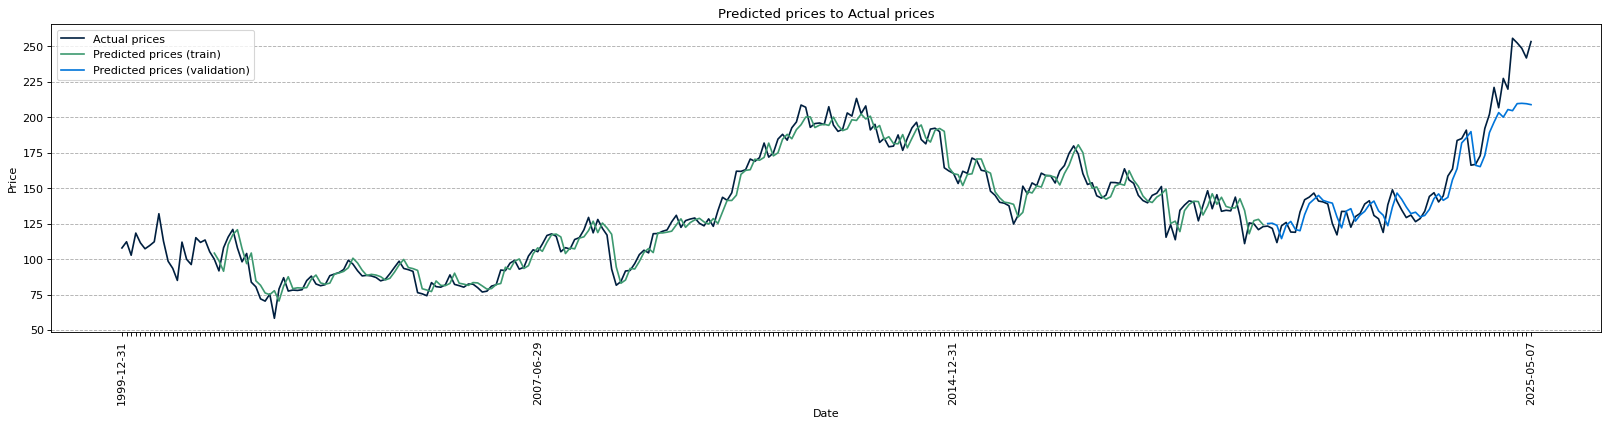

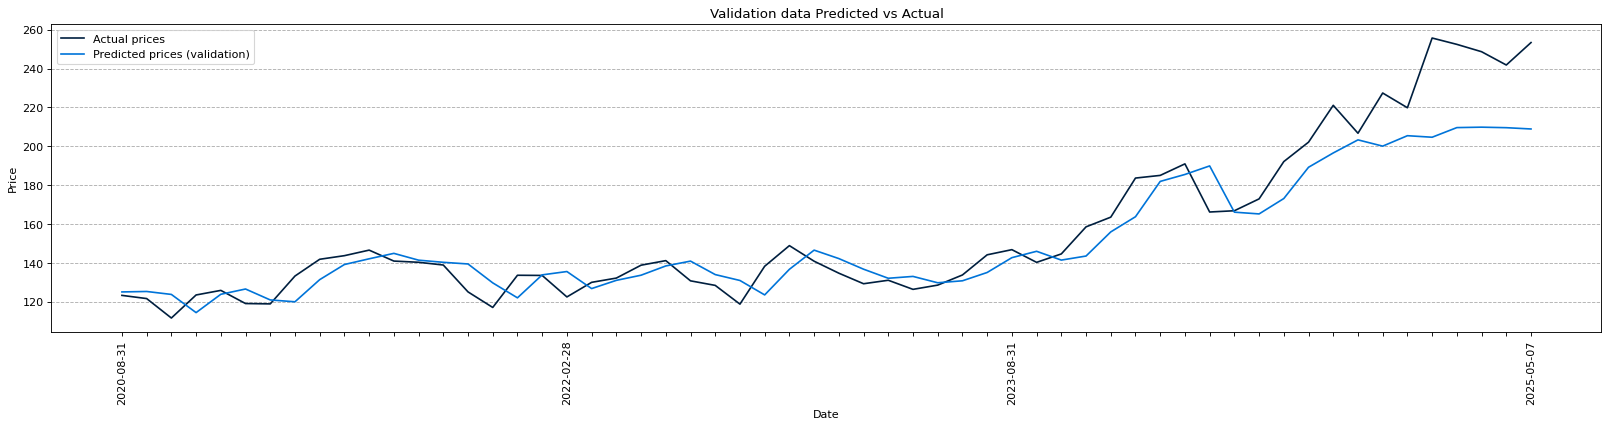

In [9]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on training data

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Predicted prices to Actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in on validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Validation data Predicted vs Actual")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

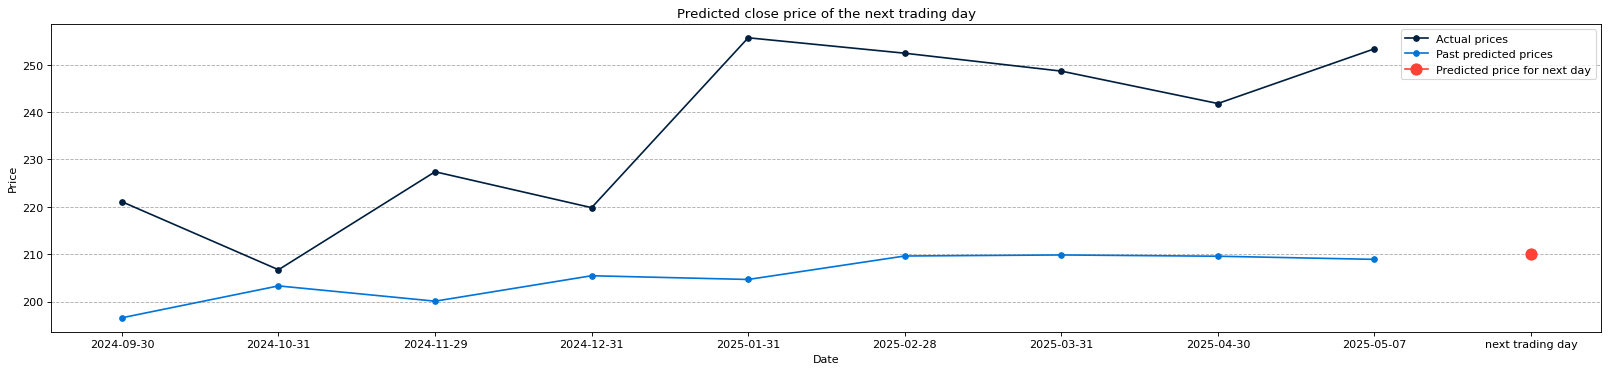

Predicted close price of the next trading day: 210.06


In [10]:
# predict tomorrow's price 

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

In [11]:
print("Predicted close price of the next trading day:", prediction)
current_close = data_close_price[num_data_points-1]
print(current_close, data_date[num_data_points-1])
print("1:buy 2:sell")
#trade = input("Enter 1 or 2: ")
#print(trade)
#this function is for testing
def evaluate_trade(current_close, prediction, trade):
    if trade == 1:
        if prediction > current_close:
            return "Trade is profitable"
        else:
            return "Trade is not profitable"
    elif trade == 2:
        if prediction < current_close:
            return "Trade is profitable"
        else:
            return "Trade is not profitable"
evaluate_trade(current_close, prediction, 1)
evaluate_trade(current_close, prediction, 2)
predicted_val = scaler.inverse_transform(predicted_val)
predicted_train = scaler.inverse_transform(predicted_train)

Predicted close price of the next trading day: 210.06030504419755
253.37 2025-05-07
1:buy 2:sell


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

print(num_data_points)
window_size = config["data"]["window_size"]

actual_train = data_close_price[window_size : split_index + window_size]
actual_val = data_close_price[split_index + window_size : split_index + window_size + len(predicted_val)]

# Define accuracy function with 5% tolerance
def accuracy_within_threshold(y_true, y_pred, threshold=0.05):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Debug: Print shape and first few values
    #print("y_true shape:", y_true.shape, "y_pred shape:", y_pred.shape)
    print("First few actual values:", y_true[:5])
    print("First few predicted values:", y_pred[:5])

    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-8
    percentage_error = np.abs((y_pred - y_true) / (y_true + epsilon))

    within_threshold = percentage_error <= threshold
    accuracy = np.mean(within_threshold) * 100  # Convert to percentage

    return accuracy

# Compute accuracy
train_accuracy = accuracy_within_threshold(actual_train, predicted_train)
val_accuracy = accuracy_within_threshold(actual_val, predicted_val)

# Print results
print(f"Train Accuracy (within 5%): {train_accuracy:.2f}%")
print(f"Validation Accuracy (within 5%): {val_accuracy:.2f}%")

306
First few actual values: [ 99.95  91.72 108.07 115.59 120.96]
First few predicted values: [104.23758756  98.89015132  91.46651241 110.23395933 117.24261088]
First few actual values: [123.31 121.67 111.66 123.52 125.88]
First few predicted values: [125.08389641 125.31822778 123.7994878  114.44761982 123.87058398]
Train Accuracy (within 5%): 66.67%
Validation Accuracy (within 5%): 48.28%


In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. prepare predictions and actuals
predicted_val_unscaled = predicted_val
actual_val_unscaled = data_y_val

# 2. Get current prices that correspond to each prediction
# These are the prices before each predicted value in the window
# The validation data starts at: split_index + window_size
price_start_index = split_index + config["data"]["window_size"]
current_prices = data_close_price[price_start_index - 1 : price_start_index - 1 + len(predicted_val_unscaled)]

# 3. Calculate expected return from BERT prediction
expected_returns = (predicted_val_unscaled - current_prices) / current_prices

# 4. Create binary labels based on profitability threshold
profit_threshold = 0.02  # 2% gain
labels = (expected_returns > profit_threshold).astype(int)  # 1 = profitable, 0 = not

# 5. Prepare features — use expected returns, or combine with current price
# Option A: Use expected returns only, only use this as a backup
#X = expected_returns.reshape(-1, 1)

# Option B: Use both current price and predicted price
X = np.vstack((current_prices, predicted_val_unscaled)).T
y = labels
# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(34), np.int64(1): np.int64(6)}


In [14]:


# 7. Train Gradient Boosting model
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# 8. Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Profitability Accuracy: {acc * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

#these are for further stats or if something goes wrong
#print("Length of predicted_val_bert:", len(predicted_val))
#print("Length of actual_val_prices:", len(data_y_val))  # or the variable you're comparing against
#print("Predicted val BERT:", predicted_val.flatten())
#print("Actual val prices:", actual_val.flatten())
print("Profit labels:", y)


Gradient Boosting Profitability Accuracy: 88.89%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.50      0.50      0.50         2

    accuracy                           0.89        18
   macro avg       0.72      0.72      0.72        18
weighted avg       0.89      0.89      0.89        18

Profit labels: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


def prepare_linear_data(prices, window_size):
    X = []
    y = []
    for i in range(len(prices) - window_size):
        X.append(prices[i:i + window_size])
        y.append(prices[i + window_size])
    return np.array(X), np.array(y)

window_size = config["data"]["window_size"]
X, y = prepare_linear_data(data_close_price, window_size)

split_index = int(len(y) * config["data"]["train_split_size"])
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
threshold = 0.05  # 5%
train_correct = np.abs(y_train - y_train_pred) / y_train <= threshold
val_correct = np.abs(y_val - y_val_pred) / y_val <= threshold

train_accuracy = np.mean(train_correct) * 100
val_accuracy = np.mean(val_correct) * 100

print(f"Linear Regression Train Threshold Accuracy (within 5%): {train_accuracy:.2f}%")
print(f"Linear Regression Validation Threshold Accuracy (within 5%): {val_accuracy:.2f}%")

Linear Regression Train Threshold Accuracy (within 5%): 62.72%
Linear Regression Validation Threshold Accuracy (within 5%): 58.62%


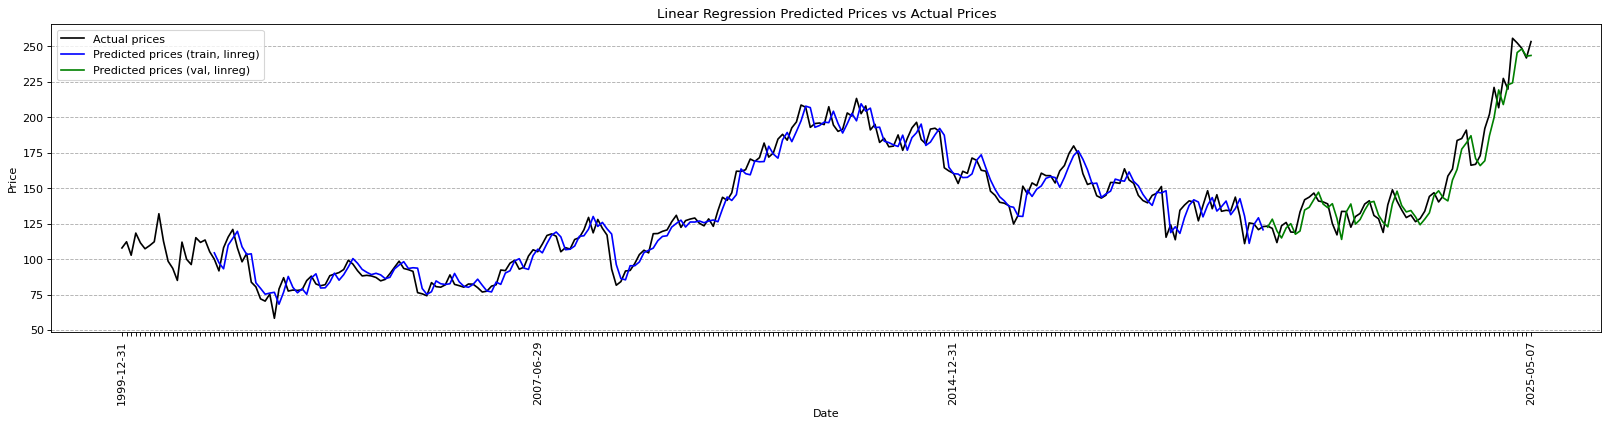

In [16]:
inv_pred_train_linreg = y_train_pred
inv_pred_val_linreg = y_val_pred
inv_data_close_price = data_close_price

# Allocate space for plotting
to_plot_train_pred_linreg = np.zeros(num_data_points)
to_plot_val_pred_linreg = np.zeros(num_data_points)

# Place predictions at proper indices
to_plot_train_pred_linreg[config["data"]["window_size"]:split_index + config["data"]["window_size"]] = inv_pred_train_linreg
to_plot_val_pred_linreg[split_index + config["data"]["window_size"]:] = inv_pred_val_linreg

# Replace 0s with None so matplotlib skips them
to_plot_train_pred_linreg = np.where(to_plot_train_pred_linreg == 0, None, to_plot_train_pred_linreg)
to_plot_val_pred_linreg = np.where(to_plot_val_pred_linreg == 0, None, to_plot_val_pred_linreg)

# Plot full price graph
plt.figure(figsize=(25, 5), dpi=80)
plt.plot(data_date, inv_data_close_price, label="Actual prices", color="black")
plt.plot(data_date, to_plot_train_pred_linreg, label="Predicted prices (train, linreg)", color="blue")
plt.plot(data_date, to_plot_val_pred_linreg, label="Predicted prices (val, linreg)", color="green")
plt.title("Linear Regression Predicted Prices vs Actual Prices")
xticks = [data_date[i] if ((i % config["plots"]["xticks_interval"] == 0 and (num_data_points - i) > config["plots"]["xticks_interval"]) or i == num_data_points - 1) else None for i in range(num_data_points)]
x = np.arange(0, len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()